In [14]:
import pandas as pd
from ast import literal_eval
from mlxtend.preprocessing import TransactionEncoder

#Es llegeix dels fitxers
df = pd.read_csv("fitness_revo_full.csv")
new_df = pd.read_csv("referencies.csv")
new_df = new_df[["ref"]].applymap(literal_eval)
referencies = new_df["ref"]
new_df.index=df["title"]

#Es transformen les referències en transacció (TRUE FALSE) per a aplicacions de Machine Learning.
te = TransactionEncoder()
te_ary = te.fit(referencies).transform(referencies)
df_ref = pd.DataFrame(te_ary, columns=te.columns_)

df_ref.to_csv("referencies_encoded.csv", ",")
'''
A refInteractive.html i refRules.html hi ha els gràfics resultants d'aplicar l'agorisme Apriori al fitxer referencies_encoded.csv
Els gràfics són fets amb R. Es pot trobar el codi que els genera al fitxer apriori_revo.R
'''

"\nA refInteractive.html i refRules.html hi ha els gràfics resultants d'aplicar l'agorisme Apriori al fitxer referencies_encoded.csv\nEls gràfics són fets amb R. Es pot trobar el codi que els genera al fitxer apriori_revo.R\n"

In [15]:
##WORDCLOUD a partir dels títols dels articles
import re
from nltk import pos_tag, word_tokenize
from nltk.collocations import *
import gensim
from gensim.models.phrases import Phrases
import nltk

stopwords = nltk.corpus.stopwords.words('spanish')
stopwords = stopwords + ['vs','cómo','i','ii','parte','debo','gimnasio','debes','menos','crossfit','episodio']
no_pos_in = ['DT', 'IN', 'PRP', 'CC', 'CD','MD', 'VBG', 'VBD', 'RP', 'RB']

def good_candidate(t,postag):
    v = False
    #Si es multipalabra
    if ' ' in t:
        tl = t.split(' ') #Generamos una lista de tokens
        #el token inicial y el token final deben ser alfabéticos y no pueden estar en la lista de stopwords..
        if re.match("^[a-z]+.*", tl[0]) and re.match("^[a-z]+.*", tl[-1]) and \
           tl[0] not in stopwords and tl[1] not in stopwords:
            #... ni su PoS puede estar en la lista no_pos_in
            if postag[0][1] not in no_pos_in and postag[-1][1] not in no_pos_in:
                v = True
    #Si es monopalabra
    else:
        #debe ser alfabético, y no estar en la lista de stopwords...
        if t not in stopwords and re.match("^[a-z]+.*", t):
            #y su PoS no puede estar en la lista no_pos_in
            if postag[0][1] not in no_pos_in:
                v = True
    return v
df = pd.read_csv("fitness_revo_full.csv")
doc = " ".join(df.title.tolist())
text_tokens = []
for d in (df.title.tolist()):
    text_tokens.append([w for w in word_tokenize(d.lower()) if re.match("^[a-z]+", w) and not re.match("(unknown)",w)])

phrases = Phrases(text_tokens, min_count=1, threshold=2, delimiter=b' ')
doc_tokens = [w for w in word_tokenize(doc.lower()) if re.match("^[a-z]+", w) and not re.match("(unknown)",w)]
text_phrases = phrases[doc_tokens]
text_phrases_stripped = [tp.strip('".,;:-():!?-‘’ ') for tp in text_phrases]

postag = {}

for tps in text_phrases_stripped:
    postag[tps] = nltk.pos_tag(word_tokenize(tps))

document_terms = [tps for tps in text_phrases_stripped if good_candidate(tps,postag[tps]) == True]

C:\Python\Lib\site-packages\gensim\models\phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


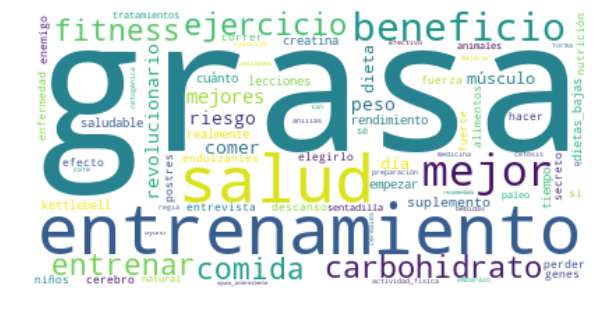

In [16]:
lemmas2display = " ".join([lu.replace(' ','_') for lu in document_terms])
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

wordcloud = WordCloud(background_color='white',max_font_size=150).generate(lemmas2display)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [17]:
#S'ordena i s'indexa per la data
df = pd.read_csv("fitness_revo_full.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values("date")
df = df.set_index('date')
#df_series = df["numComment"]

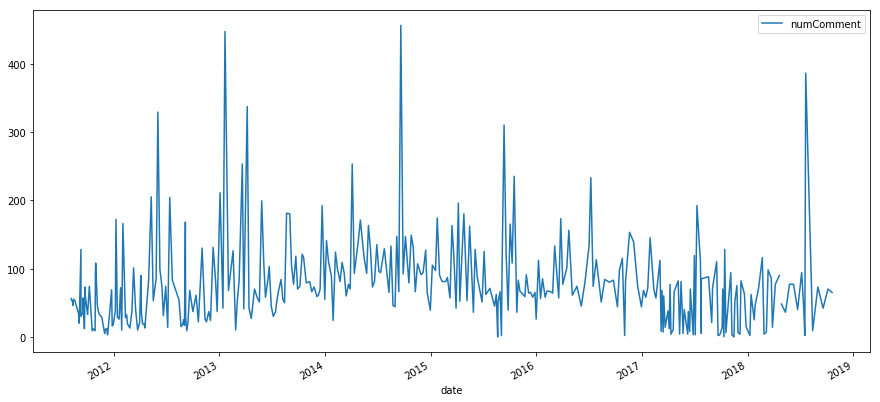

In [18]:
##Evolució del número de comentaris per article al llarg dels anys.
#S'observa una petit increment en els comentaris dels articles publicats durant els anys 2014,2015 i 2016. 
#En general, el número de comentaris es manté estable.
x = df.index
y = df['numComment']

#plot data
fig, ax = plt.subplots(figsize=(15,7))
df.plot(ax=ax)

In [19]:
#Anàlisi de sentiment dels comentaris dels 20 primers articles
import indicoio
'''
indicoio.config.api_key = "YOUR API KEY"
'''

comments = df["fullComments"].tolist()
sentiment = []
for articleComments in comments[1:20]:
    c = articleComments.split("*")
    try:
        for co in c:
            r = "Neutral"
            polarity = indicoio.sentiment(co)
            if polarity < 0.25:
                r = "Molt Dolent"
            elif polarity < 0.45:
                r = "Dolent"
            elif polarity > 0.55:
                r = "Bo"
            elif polarity > 0.75:
                r = "Molt Bo"
            sentiment.append(r)
    except:
        pass

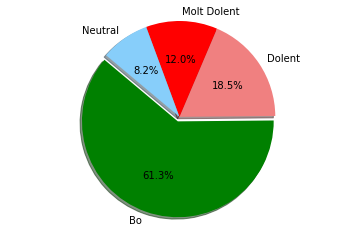

Polaritat dels comentaris en % dels 20 primers articles.


In [20]:
import matplotlib.pyplot as plt

sentiment_frame = pd.read_csv("comment_polarity.csv", ",", usecols=[1])
grouped = sentiment_frame.groupby("Polarity")
keys = list(grouped.groups.keys())
size = list(grouped.size())

# Data to plot
labels = keys
sizes = size
colors = ['green', 'lightcoral', 'red', 'lightskyblue']
explode = (0.05, 0, 0, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()
print("Polaritat dels comentaris en % dels 20 primers articles.")